In [12]:
import torch
import sklearn
import pandas as pd
import csv

In [13]:
SpamHam = pd.read_csv('spam_ham_dataset.csv')
SpamHam.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [14]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

SpamHam['clean_text'] = SpamHam['text'].apply(clean_text)
SpamHam['clean_text'].head(5)


0    subject enron methanol meter this is a follow ...
1    subject hpl nom for january see attached file ...
2    subject neon retreat ho ho ho we re around to ...
3    subject photoshop windows office cheap main tr...
4    subject re indian springs this deal is to book...
Name: clean_text, dtype: object

In [15]:
def create_vocab(texts):
    vocab = set()
    for text in texts:
        words = text.split()
        vocab.update(words)
    return {word: idx for idx, word in enumerate(sorted(vocab))}

def text_to_bow(text, vocab):
    vector = torch.zeros(len(vocab))
    for word in text.split():
        if word in vocab:
            vector[vocab[word]] += 1
    return vector

vocabulary = create_vocab(SpamHam['clean_text'])
X = torch.stack([text_to_bow(text, vocabulary) for text in SpamHam['clean_text']])
y = torch.tensor(SpamHam['label_num'].values)


# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert PyTorch tensors to NumPy arrays for scikit-learn
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_np, y_train_np)

# Make predictions
y_pred = rf_model.predict(X_test_np)

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred)
print(f'Random Forest Accuracy: {accuracy:.4f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test_np, y_pred, target_names=['Ham', 'Spam']))

Random Forest Accuracy: 0.7845

Classification Report:
              precision    recall  f1-score   support

         Ham       0.77      1.00      0.87       742
        Spam       1.00      0.24      0.39       293

    accuracy                           0.78      1035
   macro avg       0.88      0.62      0.63      1035
weighted avg       0.83      0.78      0.73      1035



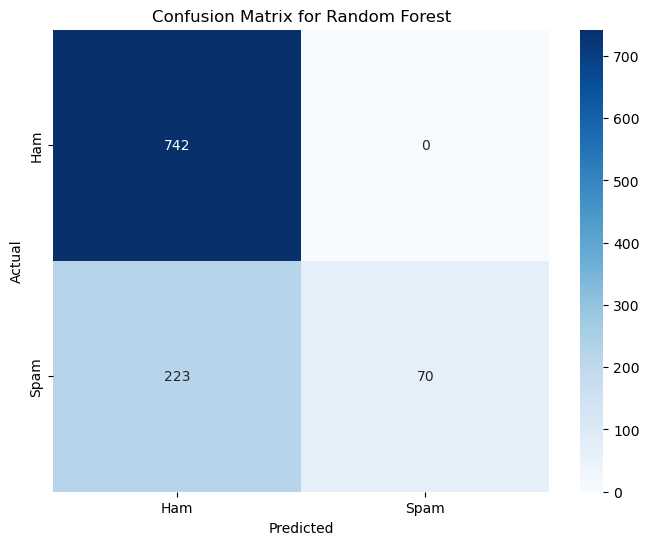

In [17]:
# Plot confusion matrix
cm = confusion_matrix(y_test_np, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [18]:
# Custom PyTorch implementation of a Decision Tree
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None
    
    def gini_impurity(self, y):
        # Calculate Gini impurity
        if len(y) == 0:
            return 0
        proportion = torch.bincount(y) / len(y)
        return 1 - torch.sum(proportion ** 2)
    
    def entropy(self, y):
        # Calculate entropy
        if len(y) == 0:
            return 0
        proportion = torch.bincount(y) / len(y)
        # Filter out zero proportions to avoid log(0)
        log_probs = torch.log2(proportion[proportion > 0])
        return -torch.sum(proportion[proportion > 0] * log_probs)
    
    def find_best_split(self, X, y, depth):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split or len(torch.unique(y)) == 1:
            return None, self._leaf_value(y)
        
        best_gain = -float('inf')
        best_feature = None
        best_threshold = None
        
        # Calculate current impurity
        if self.criterion == 'gini':
            current_impurity = self.gini_impurity(y)
        else:  # entropy
            current_impurity = self.entropy(y)
            
        # For each feature
        for feature in range(n_features):
            # Get unique values for the feature
            thresholds = torch.unique(X[:, feature])
            
            # For each possible threshold
            for threshold in thresholds:
                # Split the data
                left_idx = X[:, feature] <= threshold
                right_idx = ~left_idx
                
                # Skip if split is empty
                if torch.sum(left_idx) == 0 or torch.sum(right_idx) == 0:
                    continue
                    
                # Calculate impurity for children
                if self.criterion == 'gini':
                    left_impurity = self.gini_impurity(y[left_idx])
                    right_impurity = self.gini_impurity(y[right_idx])
                else:  # entropy
                    left_impurity = self.entropy(y[left_idx])
                    right_impurity = self.entropy(y[right_idx])
                
                # Calculate weighted impurity
                n_left = torch.sum(left_idx)
                n_right = torch.sum(right_idx)
                weighted_impurity = (n_left / n_samples) * left_impurity + (n_right / n_samples) * right_impurity
                
                # Calculate information gain
                gain = current_impurity - weighted_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        if best_gain <= 0:
            return None, self._leaf_value(y)
        
        return (best_feature, best_threshold), None
    
    def _leaf_value(self, y):
        # Return the most common class
        return torch.bincount(y).argmax().item()
    
    def _build_tree(self, X, y, depth=0):
        # Find the best split
        best_split, leaf_value = self.find_best_split(X, y, depth)
        
        # If we can't split further, return a leaf node
        if best_split is None:
            return {'leaf_value': leaf_value}
        
        feature, threshold = best_split
        
        # Split the data
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx
        
        # Recursively build the left and right branches
        left_branch = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_branch = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        
        return {'feature': feature, 'threshold': threshold, 'left': left_branch, 'right': right_branch}
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        # If we're at a leaf node
        if 'leaf_value' in node:
            return node['leaf_value']
        
        # Otherwise, navigate the tree
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
    
    def predict(self, X):
        return torch.tensor([self._predict_sample(x, self.tree) for x in X])

In [19]:
# PyTorch implementation of Random Forest
class PyTorchRandomForest:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, criterion='gini'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.trees = []
    
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        # Sample with replacement
        indices = torch.randint(0, n_samples, (n_samples,))
        return X[indices], y[indices]
    
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            # Bootstrap sample
            X_sample, y_sample = self._bootstrap_sample(X, y)
            
            # Create and train a decision tree
            tree = DecisionTree(max_depth=self.max_depth, 
                               min_samples_split=self.min_samples_split,
                               criterion=self.criterion)
            tree.fit(X_sample, y_sample)
            
            # Add tree to forest
            self.trees.append(tree)
        return self
    
    def predict(self, X):
        # Collect predictions from all trees
        predictions = torch.zeros(X.shape[0], self.n_estimators, dtype=torch.long)
        
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        
        # Use majority vote to make final prediction
        final_pred = torch.zeros(X.shape[0], dtype=torch.long)
        for i in range(X.shape[0]):
            final_pred[i] = torch.bincount(predictions[i]).argmax()
        
        return final_pred

In [20]:
# Train our custom PyTorch Random Forest model
torch_rf = PyTorchRandomForest(n_estimators=10, max_depth=5)
torch_rf.fit(X_train, y_train)

# Make predictions
y_torch_pred = torch_rf.predict(X_test)

# Evaluate the model
torch_accuracy = accuracy_score(y_test.numpy(), y_torch_pred.numpy())
print(f'PyTorch Random Forest Accuracy: {torch_accuracy:.4f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test.numpy(), y_torch_pred.numpy(), target_names=['Ham', 'Spam']))

PyTorch Random Forest Accuracy: 0.8551

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.80      0.89       742
        Spam       0.67      0.98      0.79       293

    accuracy                           0.86      1035
   macro avg       0.83      0.89      0.84      1035
weighted avg       0.90      0.86      0.86      1035



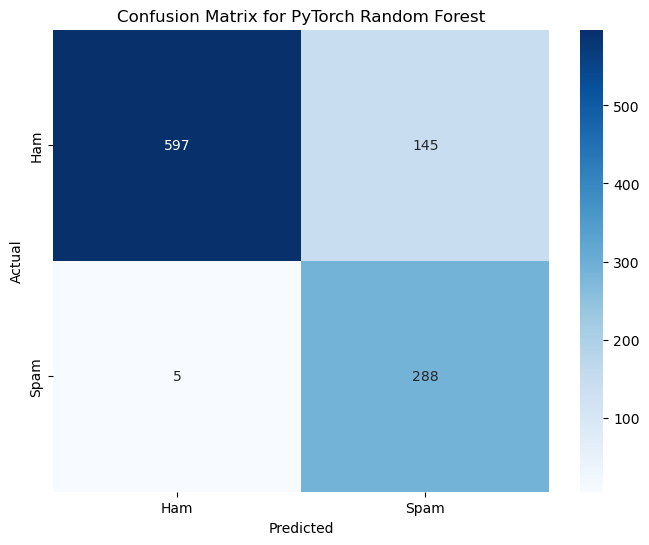

In [21]:
# Plot confusion matrix for PyTorch Random Forest
torch_cm = confusion_matrix(y_test.numpy(), y_torch_pred.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(torch_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for PyTorch Random Forest')
plt.show()

scikit-learn Random Forest Accuracy: 0.7845
PyTorch Random Forest Accuracy: 0.8551


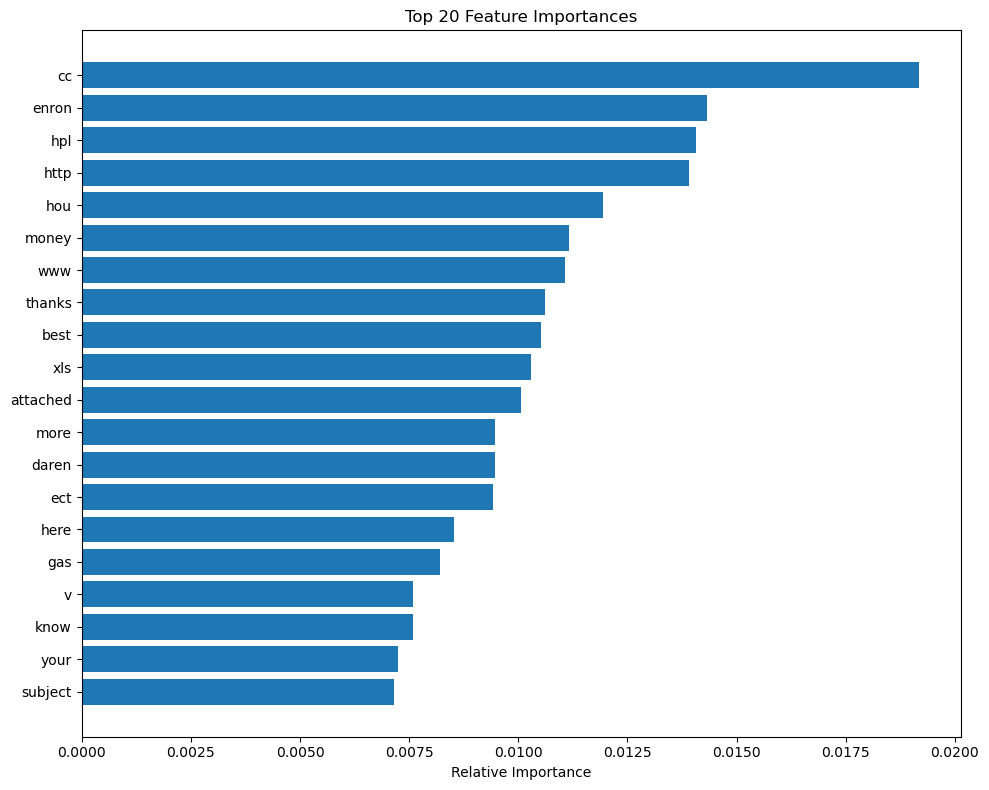

In [22]:
# Compare scikit-learn and PyTorch implementations
print(f'scikit-learn Random Forest Accuracy: {accuracy:.4f}')
print(f'PyTorch Random Forest Accuracy: {torch_accuracy:.4f}')

# Plot feature importances from scikit-learn model
feature_importances = rf_model.feature_importances_
# Get the top 20 features
indices = np.argsort(feature_importances)[-20:]

plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')

# Convert indices to words for better visualization
words = [list(vocabulary.keys())[i] for i in indices]
plt.yticks(range(len(indices)), words)
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()